Following code process the file velib dataset.mmap 

input: velib_dataset.mmap, velib_metadata.json
=instant updates of all stations for period 2023-2025, sorted by (station, time), with necessary metadatas

output: mini version interpolated on a time grid (freq=hour)
-> weight 100 Mega only !
-> fast and easy manipulation with xarray

<details>
<summary>üß† Voir le code (cliquer pour d√©rouler)</summary>

```python


import numpy as np
import json
from tqdm import tqdm
from raw_data.by_station.load_metadata import load_velib_metadata

# === Chargement ===
meta = load_velib_metadata()
data = meta["data"]
station_offsets = meta["station_offsets"]

# === P√©riode cible ===
t0 = np.datetime64("2023-01-01T00")
t1 = np.datetime64("2024-12-31T23")
times = np.arange(t0, t1 + np.timedelta64(1, "h"), np.timedelta64(1, "h"))
n_hours = len(times)
n_stations = len(station_offsets)
n_features = 4  # vm_sum, vae_sum, flux_plus, flux_minus

# === Allocation du memmap ===
mmap_path =  "raw_data/by_station/mini_velib_dataset.mmap"
velib = np.memmap(mmap_path, dtype=np.int8, mode="w+", shape=(n_stations, n_hours, n_features))
capacities = {}

# === Conversion minutes absolues ‚Üí datetime64[h] ===
origin = np.datetime64("2023-01-01T00")
def temps_to_datetime64(temps_minutes):
    return origin + temps_minutes.astype("timedelta64[m]")

# === Traitement station par station ===
for i, (station_id, months) in enumerate(tqdm(station_offsets.items())):
    print(f"operating station {i}")
    # --- r√©cup√©ration bornes globales ---
    month_keys = sorted(months.keys())
    start = months[month_keys[0]][0]
    end   = months[month_keys[-1]][1]

    # --- lecture bloc station ---
    block = data[start:end]

    t_abs = block["temps_absolu"].astype(np.int64)
    t_all = temps_to_datetime64(t_abs)
    vm_all = (
        block["vm_disponibles"]
        + block["vm_indisponibles"]
        + block["vm_disponibles_station_plus"]
        + block["vm_indisponibles_station_plus"]
    ).astype(np.int16)

    vae_all = (
        block["vae_disponibles"]
        + block["vae_indisponibles"]
        + block["vae_disponibles_plus"]
        + block["vae_indisponibles_plus"]
    ).astype(np.int16)

    # === 1Ô∏è‚É£ Calcul des flux bruts ===
    total = vm_all + vae_all
    cap = total + block["diapason_disponibles"].astype(np.int16) 
    delta_tot = np.diff(total, prepend=total[0])
    flux_plus_raw = np.clip(delta_tot, 0, 127).astype(np.int8)
    flux_minus_raw = np.clip(-delta_tot, 0, 127).astype(np.int8)

    # === 2Ô∏è‚É£ Agr√©gation horaire des flux ===
    # conversion des timestamps en indices d'heure (0, 1, 2, ...)
    hour_index = ((t_all - t0) / np.timedelta64(1, "h")).astype(int)
    valid = (hour_index >= 0) & (hour_index < n_hours)
    hour_index = hour_index[valid]
    flux_plus_binned = np.bincount(hour_index, weights=flux_plus_raw[valid], minlength=n_hours)
    flux_minus_binned = np.bincount(hour_index, weights=flux_minus_raw[valid], minlength=n_hours)

    # === 3Ô∏è‚É£ Interpolation des niveaux ===
    t_float = t_all.astype("datetime64[m]").astype(np.float64)
    times_float = times.astype("datetime64[h]").astype(np.float64) * 60  # minutes
    vm_interp = np.interp(times_float, t_float, vm_all)
    vae_interp = np.interp(times_float, t_float, vae_all)

    # === 4Ô∏è‚É£ Bloc final ===
    vm_i8 = np.clip(vm_interp, 0, 127).astype(np.int8)
    vae_i8 = np.clip(vae_interp, 0, 127).astype(np.int8)
    flux_plus_i8 = np.clip(flux_plus_binned, 0, 127).astype(np.int8)
    flux_minus_i8 = np.clip(flux_minus_binned, 0, 127).astype(np.int8)

    block_out = np.stack(
        [vm_i8, vae_i8, flux_plus_i8, flux_minus_i8],
        axis=-1
    )
    velib[i, :, :] = block_out

    # --- capacit√© max ---
    capacities[str(station_id)] = int(np.max(cap))

# === flush sur disque ===
velib.flush()

print("‚úÖ Base horaire mmap cr√©√©e :", velib.shape)
print("‚úÖ Capacit√©s stations :", len(capacities))
print("‚úÖ Fichier :", mmap_path)

import pandas as pd
spatial_datas = pd.read_csv("prepare_data/spatial_datas.csv", dtype = {"code_station": str})

# cr√©er un dict {station_id: (lat, lon)}
coors_dict = dict(zip(spatial_datas["code_station"], 
                      zip(spatial_datas["latitude"], spatial_datas["longitude"])))


# 3Ô∏è‚É£ D√©faut si station absente (au sud-ouest de Paris)
default_coords = (48.75, 2.3)

# 4Ô∏è‚É£ R√©cup√©rer les coordonn√©es pour toutes les stations connues
coords_all = {
    station: coors_dict.get(station, default_coords)
    for station in station_offsets.keys()
}

# 5Ô∏è‚É£ S√©parer en deux dictionnaires : latitude / longitude
latitudes = {sid: lat for sid, (lat, lon) in coords_all.items()}
longitudes = {sid: lon for sid, (lat, lon) in coords_all.items()}


import json
from datetime import datetime

meta_mini = {
    "station_ids": list(station_offsets.keys()),       # id des stations
    "capacities": capacities,                          # capacit√©s max
    "columns": ["vm_sum", "vae_sum", "flux_plus", "flux_minus"],
    "time_start": str(t0),
    "time_end": str(t1),
    "time_freq": "1H",                                 # fr√©quence horaire
    "created_at": str(datetime.now()),
    "latitudes": {sid: latitudes[sid] for sid in list(station_offsets.keys())},
    "longitudes": {sid: longitudes[sid] for sid in list(station_offsets.keys())},
    "data_file": mmap_path
}

with open("raw_data/by_station/mini_velib_metadata.json", "w") as f:
    json.dump(meta_mini, f, indent=2)


</details> ```


In [2]:
print("‚úÖ Base horaire mmap cr√©√©e :", velib.shape)
print("‚úÖ Capacit√©s stations :", len(capacities))
print("‚úÖ Fichier :", mmap_path)

‚úÖ Base horaire mmap cr√©√©e : (1551, 17544, 4)
‚úÖ Capacit√©s stations : 1551
‚úÖ Fichier : raw_data/by_station/mini_velib_dataset.mmap


Small tutorial for using the new database

In [1]:
from raw_data.by_station.mini_load_metadata import load_mini

ds = load_mini()
ds

c:\Users\arman\Collaboration_Smovengo\Collaboration_Smovengo\algo\raw_data\by_station\mini_load_metadata.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = xr.DataArray(


<xarray.Dataset>
Dimensions:     (station: 1551, time: 17544)
Coordinates:
  * station     (station) <U12 '000000002' '10001' ... '9999970' '9999980'
    latitude    (station) float64 48.75 48.75 48.75 48.87 ... 48.89 48.75 48.75
    longitude   (station) float64 2.3 2.3 2.3 2.35 2.354 ... 2.224 2.206 2.3 2.3
    capacite    (station) int32 16 63 0 19 49 18 30 19 ... 26 21 43 30 23 38 0 0
  * time        (time) datetime64[ns] 2023-01-01 ... 2024-12-31T23:00:00
Data variables:
    vm_sum      (station, time) int8 2 2 2 2 2 2 2 2 2 2 ... 0 0 0 0 0 0 0 0 0 0
    vae_sum     (station, time) int8 11 11 11 11 11 11 11 11 ... 0 0 0 0 0 0 0 0
    flux_plus   (station, time) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    flux_minus  (station, time) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

In [28]:
import numpy as np
import xarray as xr
from tqdm import tqdm

# S√©lection des 24*7 premi√®res heures
subset_time = ds.time[:24*7]  # 168 heures
vm = ds.vm_sum.sel(time=subset_time)
vae = ds.vae_sum.sel(time=subset_time)
cap = ds.capacite
reste = cap.values[:, None] - vm.values - vae.values

# Grille spatiale
lats = ds.latitude.values
lons = ds.longitude.values
lon_edges = np.linspace(lons.min(), lons.max(), 65)  # 200 pixels ‚Üí 201 edges
lat_edges = np.linspace(lats.min(), lats.max(), 65)

t_steps = subset_time.size
grid_rgb = np.zeros((t_steps, 64, 64, 3), dtype=np.uint8)

for i in tqdm(range(t_steps)):
    vm_t = vm.isel(time=i).values
    vae_t = vae.isel(time=i).values
    reste_t = reste[:, i]

    # Comptage par pixel avec histogram2d
    vm_i, _, _ = np.histogram2d(lats, lons, bins=[lat_edges, lon_edges], weights=vm_t)
    vae_i, _, _ = np.histogram2d(lats, lons, bins=[lat_edges, lon_edges], weights=vae_t)
    reste_i, _, _ = np.histogram2d(lats, lons, bins=[lat_edges, lon_edges], weights=reste_t)

    # On clippe √† 255 pour tenir dans uint8
    grid_rgb[i, :, :, 0] = np.clip(reste_i, 0, 255).astype(np.uint8)
    grid_rgb[i, :, :, 1] = np.clip(vm_i, 0, 255).astype(np.uint8)
    grid_rgb[i, :, :, 2] = np.clip(vae_i, 0, 255).astype(np.uint8)

# Coordonn√©es centr√©es sur les pixels
lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2

# Xarray
grid_ds = xr.DataArray(
    grid_rgb,
    dims=('time', 'lat', 'lon', 'channel'),
    coords={'time': subset_time, 'lat': lat_centers, 'lon': lon_centers, 'channel': ['R','G','B']}
)


  0%|          | 0/168 [00:00<?, ?it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 168/168 [00:01<00:00, 165.45it/s]


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.ndimage import gaussian_filter

# --- Fonction de normalisation RGB par pixel ---
def normalize_rgb(arr):
    arr_disp = arr.astype(np.float32)
    sum_c = arr_disp.sum(axis=-1, keepdims=True)
    arr_disp = np.where(sum_c != 0, 255 * arr_disp / sum_c, 255)
    return arr_disp.astype(np.uint8)

# --- Fonction pour lisser l'image ---
def smooth_rgb(arr, sigma=2, n_iter=2):
    arr_smooth = arr.astype(np.float32).copy()
    for _ in range(n_iter):
        for i in range(3):
            arr_smooth[..., i] = gaussian_filter(arr_smooth[..., i], sigma=sigma)
    return arr_smooth.astype(np.uint8)

# --- Pr√©parer la figure ---
fig, axes = plt.subplots(1, 2, figsize=(12,6))
im0 = axes[0].imshow(smooth_rgb(normalize_rgb(grid_ds.values[0]), sigma=2, n_iter=2),
                     origin='lower', interpolation='nearest')
axes[0].set_title("Original liss√©")
im1 = axes[1].imshow(normalize_rgb(approx_rgb[0]),
                     origin='lower', interpolation='nearest')
axes[1].set_title("Approximation Wavelet")

# --- Fonction de mise √† jour pour l'animation ---
def update(frame):
    im0.set_data(smooth_rgb(normalize_rgb(grid_ds.values[frame]), sigma=2, n_iter=2))
    im1.set_data(normalize_rgb(grid_ds.values[frame]))
    return im0, im1

# --- Cr√©ation de l'animation ---
anim = FuncAnimation(fig, update, frames=grid_ds.shape[0], interval=100, blit=False)

# --- Sauvegarde en GIF ---
writer = PillowWriter(fps=10)
anim.save("velib_animation.gif", writer=writer)

plt.close(fig)
print("Animation enregistr√©e sous velib_animation.gif")


C:\Users\arman\AppData\Local\Temp\ipykernel_16956\1254796410.py:10: RuntimeWarning: invalid value encountered in divide
  arr_disp = np.where(sum_c != 0, 255 * arr_disp / sum_c, 255)
C:\Users\arman\AppData\Local\Temp\ipykernel_16956\1254796410.py:10: RuntimeWarning: invalid value encountered in divide
  arr_disp = np.where(sum_c != 0, 255 * arr_disp / sum_c, 255)


Animation enregistr√©e sous velib_animation.gif


In [7]:
import pywt
import numpy as np

def threshold_coeffs(coeffs, method='sigma', value=3.0):
    """
    Applique un seuil aux coefficients de d√©tails pour ne garder que les significatifs.
    - method='sigma' : seuil = value * std(coeffs de d√©tails)
    - method='hard' : seuil = valeur fixe
    """
    coeffs_thresh = [coeffs[0]]  # approximation reste inchang√©e

    for d in coeffs[1:]:
        d_thresh = {}
        for k, v in d.items():
            if method == 'sigma':
                sigma = np.std(v)
                t = value * sigma
            else:
                t = value
            # Seuil hard : z√©ro si |v| < t
            d_thresh[k] = np.where(np.abs(v) < t, 0, v)
        coeffs_thresh.append(d_thresh)
    return coeffs_thresh

coeffs_channels_sig = {}
for c in ['R','G','B']:
    data = grid_ds.sel(channel=c).astype(np.float32).values
    coeffs = pywt.wavedecn(data, wavelet='db2', level=2)
    # Ne garder que les coefficients significatifs
    coeffs_sig = threshold_coeffs(coeffs, method='sigma', value=3.0)
    coeffs_channels_sig[c] = coeffs_sig
    
    print(f"Canal {c} : m√©moire ondelette totale = {coeffs_mem_mb(coeffs_sig):.2f} MB")


Canal R : m√©moire ondelette totale = 26.78 MB
Canal G : m√©moire ondelette totale = 26.78 MB
Canal B : m√©moire ondelette totale = 26.78 MB


In [ ]:
import pywt

# Exemple sur le canal vert (vm_sum)
data = grid_ds.sel(channel='G').values  # shape = (t, lat, lon)

# Ondelette 3D discr√®te
coeffs = pywt.wavedecn(data, wavelet='db2', level=2)  # 2 niveaux de d√©composition

# coeffs est une liste : [approximation, {d√©tails}]


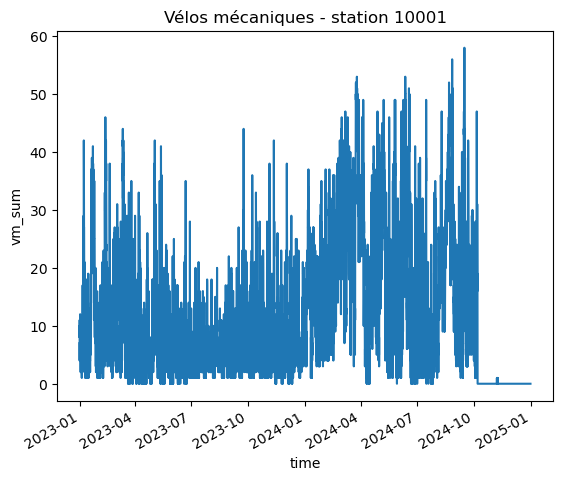

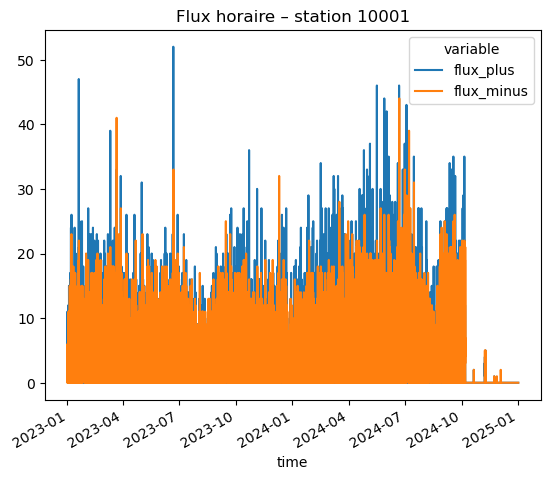

In [2]:
import matplotlib.pyplot as plt

# Exemple 1 : √©volution vm_sum pour une station
station_idx = '10001'
ds["vm_sum"].sel(station=station_idx).plot()
plt.title(f"V√©los m√©caniques - station {station_idx}")
plt.show()

# Exemple 2 : plot 2 colonnes sur le mm graphe (plus compliqu√©)
ds.isel(station=ds.get_index("station").get_loc(station_idx))[
    ["flux_plus", "flux_minus"]
].to_array().plot.line(x="time")

plt.title(f"Flux horaire ‚Äì station {station_idx}")
plt.show()

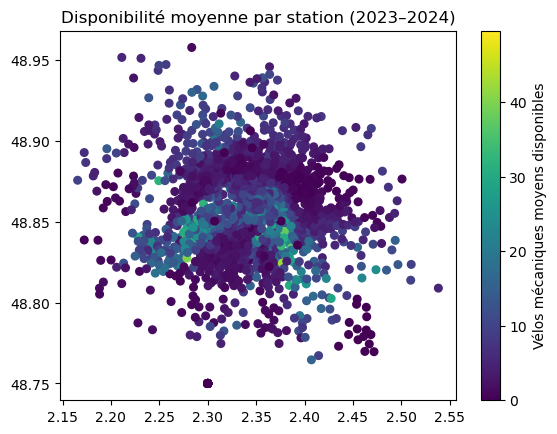

In [3]:
daily_mean = ds["vm_sum"].resample(time="1D").mean()
mean_day = daily_mean.mean(dim="time")

plt.scatter(ds.longitude, ds.latitude, c=mean_day, cmap="viridis", s=30)
plt.colorbar(label="V√©los m√©caniques moyens disponibles")
plt.title("Disponibilit√© moyenne par station (2023‚Äì2024)")
plt.show()

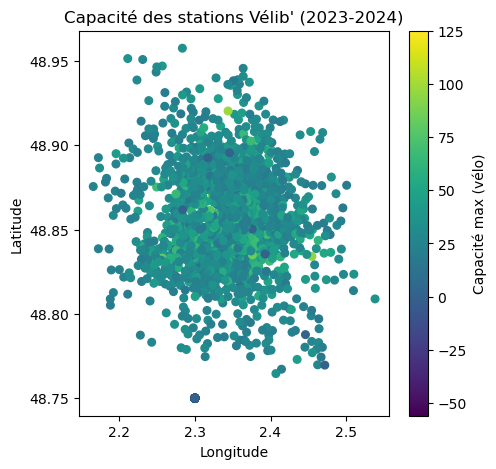

In [8]:
import matplotlib.pyplot as plt

# Coordonn√©es
lats = ds.latitude.values    # shape (station,)
lons = ds.longitude.values  # shape (station,)
caps = ds.capacite.values   # shape (station,)

plt.figure(figsize=(5, 5))
sc = plt.scatter(lons, lats, c=caps, cmap="viridis", s=30)
plt.colorbar(sc, label="Capacit√© max (v√©lo)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Capacit√© des stations V√©lib' (2023-2024)")
plt.show()


Attention petit bug, pour 4/5 stations tres bizares 
qui ont d√©pass√© la capacit√© max attendue (stations √©ph√®meres ??)

In [13]:
caps = ds.capacite.values       # numpy array shape (station,)
stations = ds.station.values    # station IDs correspondants

idx_min = caps.argmin()
idx_max = caps.argmax()

print("Station avec capacit√© min :", stations[idx_min], "‚Üí", caps[idx_min])
print("Station avec capacit√© max :", stations[idx_max], "‚Üí", caps[idx_max])


Station avec capacit√© min : 32051 ‚Üí -56
Station avec capacit√© max : 16200 ‚Üí 125


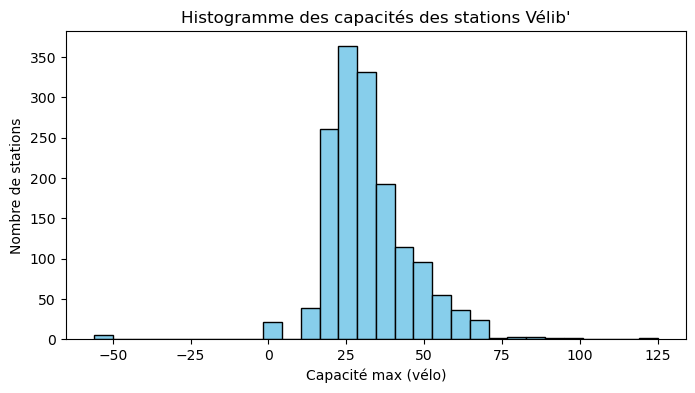

In [14]:
import matplotlib.pyplot as plt

caps = ds.capacite.values  # numpy array shape (station,)

plt.figure(figsize=(8,4))
plt.hist(caps, bins=30, color='skyblue', edgecolor='k')
plt.xlabel("Capacit√© max (v√©lo)")
plt.ylabel("Nombre de stations")
plt.title("Histogramme des capacit√©s des stations V√©lib'")
plt.show()


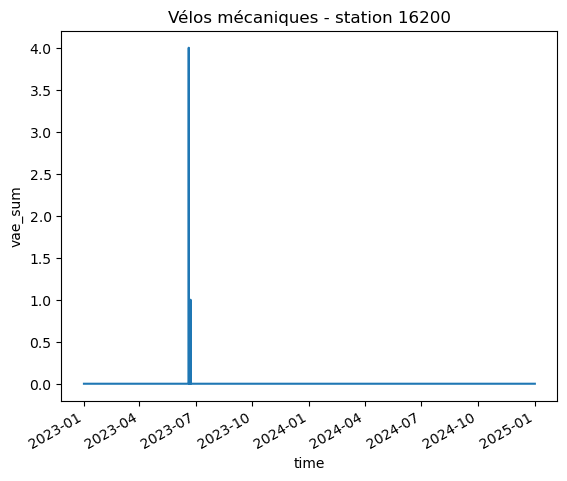

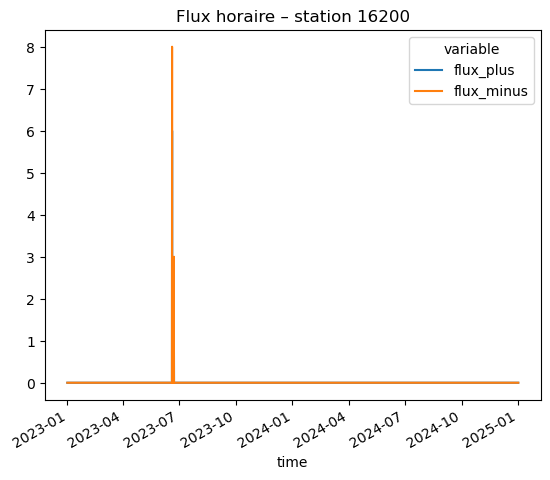

In [17]:
import matplotlib.pyplot as plt

# Exemple 1 : √©volution vm_sum pour une station
station_idx = '16200'
ds["vae_sum"].sel(station=station_idx).plot()
plt.title(f"V√©los m√©caniques - station {station_idx}")
plt.show()

# Exemple 2 : plot 2 colonnes sur le mm graphe (plus compliqu√©)
ds.isel(station=ds.get_index("station").get_loc(station_idx))[
    ["flux_plus", "flux_minus"]
].to_array().plot.line(x="time")

plt.title(f"Flux horaire ‚Äì station {station_idx}")
plt.show()